# Random Forest Regressor Explained
### Jeanine Buyck

This is the code that was for illustration purposes in the `TODO insert title and link` article.

## Generate synthetic data for use in examples

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt

from math import pi, sqrt, ceil
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

In [2]:
# custom modules

# this adds the parent dir to the path so we can import its modules
import sys
sys.path.insert(0,'..')

# this is how we'll generate data for our example
from synthetic_data.generate import sine_data

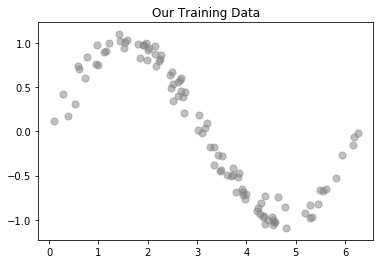

In [3]:
# generate synthetic data based on sine function
min_x = 0
max_x = 2 * pi
X, y = sine_data(
    min_x=min_x,
    max_x=max_x,
    n=100,
    amplitude=1,
    error_mean=0,
    error_std_dev=0.1
)

plt.scatter(X, y, alpha=.5, c='gray', s=50)
plt.title('Our Training Data')
plt.show()

In [4]:
# generate some x-values for plotting models later on
X_model_plot = np.linspace(min_x, max_x, num=10000, endpoint=True)

## Build a few decision trees of various depths

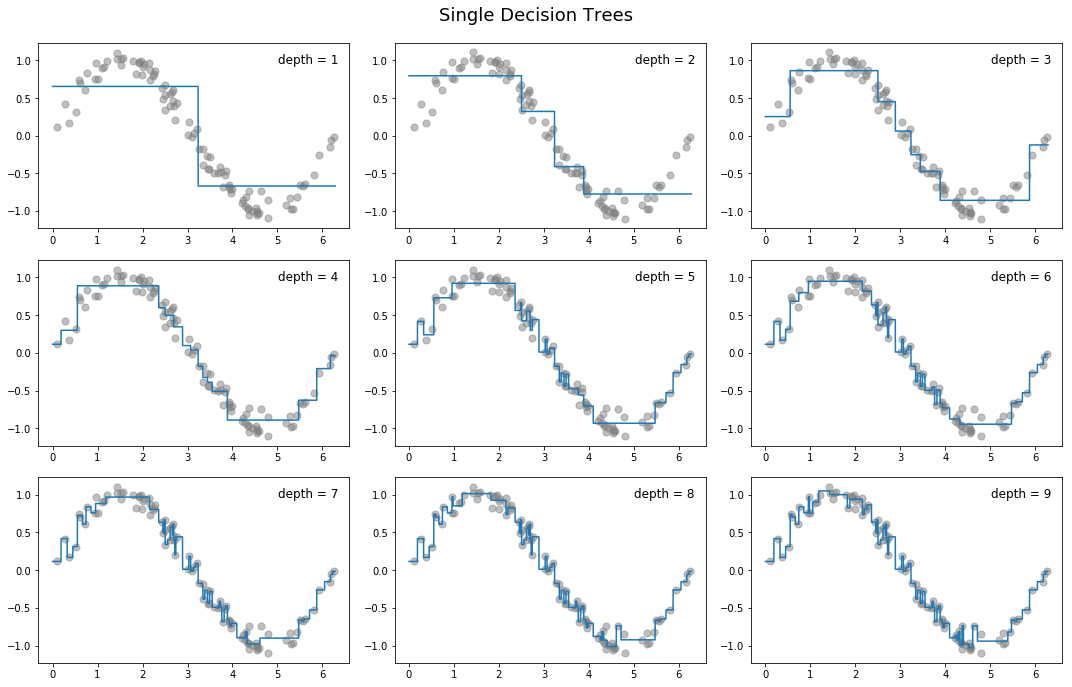

In [5]:
# this controls how many trees we'll build
tree_count = 9

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 10))

# get number of rows and cols for subplot to plot in a square grid
subplot_dim = ceil(sqrt(tree_count))

# we're going to build a total of num_trees, each at increasing depth
for depth in range(tree_count):
    max_depth = depth + 1  # off by one due to range behavior
    single_tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    single_tree.fit(X.reshape(-1, 1), y)
    tree_depth = single_tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = single_tree.predict(X_model_plot.reshape(-1, 1))
    
    plt.subplot(subplot_dim, subplot_dim, max_depth)
    plt.scatter(X, y, alpha=.5, c='gray', s=50)

    plt.plot(X_model_plot, y_model_plot, label=f'depth = {tree_depth}')
    plt.legend(handlelength=0, frameon=False, fontsize=12)
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle('Single Decision Trees', fontsize=18)
plt.show()

## Define some functions to help us with our ensembles

In [6]:
# Note that in practice, these functions should live in a module outside of this notebook.
# For ease of demonstration, they are being defined here so the reader doesn't need to
# leave the notebook while following through the expamples.

def ensemble_grow(X, y, num_trees, max_depth, bootstrap=False):
    """
    Grows num_trees individual decision trees, each with max depth of max_depth,
    and returns a list of the trained trees.
    
    Default behavior is to use the full data set (X and y) to grow each tree.
    That is, each tree is grown on the same set of data, X and y.
    
    If bootstrap is set to `True`, then a bootstrapped sample of X and y is used
    to train each tree. That is, each tree is grown on its own bootstrapped sample
    of the data, where the sample is that same size as the original X and y.
    """
    
    # this list will hold the trees we train
    trees = []
    
    for tree in range(num_trees):
        if bootstrap:
            # default behavior of `resample` is to return a sample with same size as input
            train_X, train_y = resample(X, y, replace=True)
        else:
            # just use the input X and y to train the tree
            train_X, train_y = X, y
        
        ensemble_tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
        ensemble_tree.fit(train_X.reshape(-1, 1), train_y)
        
        trees.append(ensemble_tree)
        
    return trees


def ensemble_predict(X, trees):
    """Get predictions for X by averaging predictions from the trees."""
    
    # keep track of number of trees for computing the average later
    num_trees = len(trees)
    
    # start with zeros, we will add predictions to this for each tree
    y_hat_sum = np.zeros(len(X))
    
    # get the predictions for each tree and add to running sum
    for tree in trees:
        y_hat_sum += tree.predict(X.reshape(-1, 1))
        
    # divide by total number of trees to get the average
    y_hat = y_hat_sum / num_trees
    
    return y_hat



# # TODO erase later, for dev/debug only
# y_hat_ensemble = ensemble_predict(np.array([1, 2, 3]), [single_tree, single_tree])
# print(y_hat_ensemble)


# Define some constants to use for the examples

In [7]:
num_trees=6
max_depth=2

## Build an ensemble of trees with the same max_depth, no randomness added in.

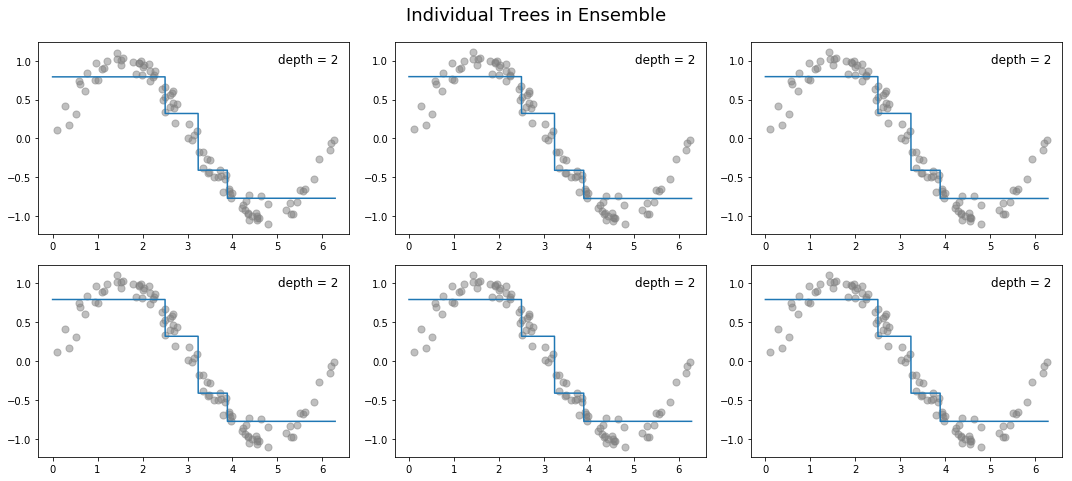

In [8]:
# TODO clean up this code
my_first_ensemble = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=num_trees, 
    max_depth=max_depth,
    bootstrap=False
)    

tree_count = len(my_first_ensemble)

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 10))

# get number of rows and cols for subplot to plot in a square grid
subplot_dim = ceil(sqrt(tree_count))

# plot the model for each tree in the ensemble on its own graph
for idx, tree in enumerate(my_first_ensemble):
    tree_depth = tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = tree.predict(X_model_plot.reshape(-1, 1))
    
    plt.subplot(subplot_dim, subplot_dim, idx+1)
    plt.scatter(X, y, alpha=.5, c='gray', s=50)

    plt.plot(X_model_plot, y_model_plot, label=f'depth = {tree_depth}')
    plt.legend(handlelength=0, frameon=False, fontsize=12)
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle('Individual Trees in Ensemble', fontsize=18)
plt.show()

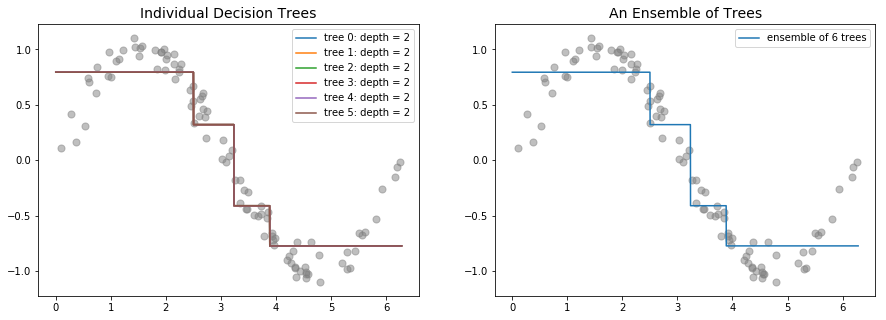

In [9]:
# TODO plot side by side: all decision tree models on one graph, next to the ensemble
# GOAL: show without bootstrapping we have not changed the model results

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 5))

# plot the model for each tree within the ensemble on the same graph
plt.subplot(1, 2, 1)
plt.title(f'Individual Decision Trees', fontsize=14)
plt.scatter(X, y, alpha=.5, c='gray', s=50)

for idx, tree in enumerate(my_first_ensemble):
    tree_depth = tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = tree.predict(X_model_plot.reshape(-1, 1))
    
    plt.plot(X_model_plot, y_model_plot, label=f'tree {idx}: depth = {tree_depth}')
    plt.legend()
    
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
#     plt.tight_layout(rect=[0, .3, 1, 0.95])


# plot the results of ensemble on another graph
plt.subplot(1, 2, 2)
plt.title(f'An Ensemble of Trees', fontsize=14)
plt.scatter(X, y, alpha=.5, c='gray', s=50)
y_model_plot = ensemble_predict(X_model_plot, my_first_ensemble)
plt.plot(X_model_plot, y_model_plot, label=f'ensemble of {len(my_first_ensemble)} trees')
plt.legend()

plt.show()

## Build an ensemble of trees with the same max_depth, but bootstrap the training data.

In [10]:
X_bootstrapped, y_bootstrapped = resample(X, y, replace=True)

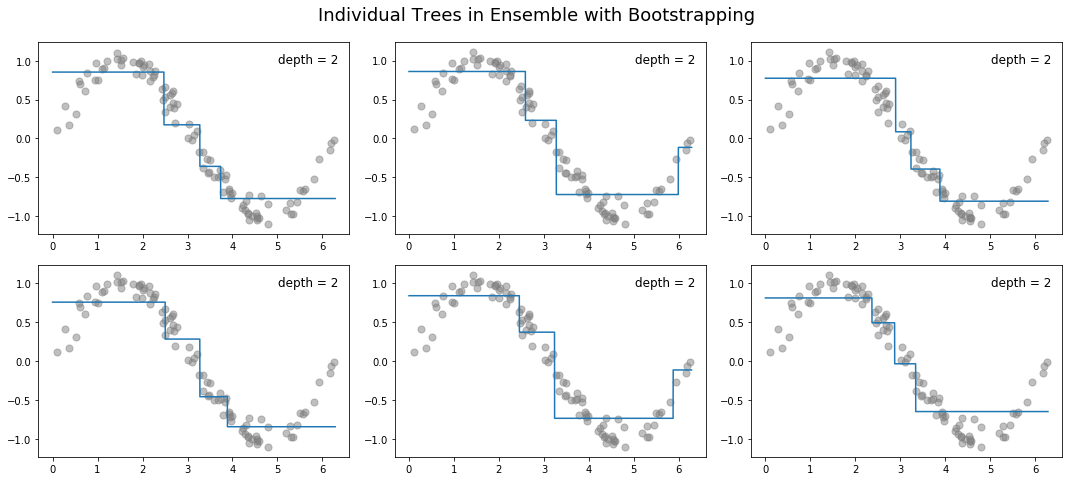

In [11]:
# TODO clean up this code
my_next_ensemble = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=num_trees, 
    max_depth=max_depth,
    bootstrap=True
)    

tree_count = len(my_next_ensemble)

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 10))

# get number of rows and cols for subplot to plot in a square grid
subplot_dim = ceil(sqrt(tree_count))

# plot the model for each tree in the ensemble on its own graph
for idx, tree in enumerate(my_next_ensemble):
    tree_depth = tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = tree.predict(X_model_plot.reshape(-1, 1))
    
    plt.subplot(subplot_dim, subplot_dim, idx+1)
    plt.scatter(X, y, alpha=.5, c='gray', s=50)

    plt.plot(X_model_plot, y_model_plot, label=f'depth = {tree_depth}')
    plt.legend(handlelength=0, frameon=False, fontsize=12)
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle('Individual Trees in Ensemble with Bootstrapping', fontsize=18)
plt.show()

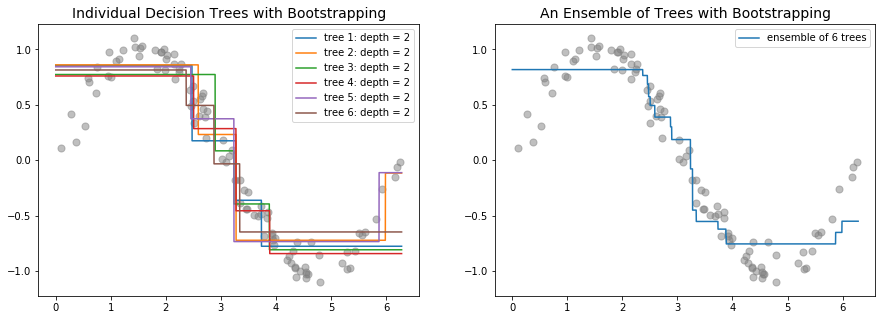

In [16]:
# TODO plot side by side: all decision tree models on one graph, next to the ensemble
# GOAL: see that not only does the ensemble produce a different result,
#       but also the curve is becoming smoother and not overfitting the data.

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 5))

# plot the model for each tree within the ensemble on the same graph
plt.subplot(1, 2, 1)
plt.title(f'Individual Decision Trees with Bootstrapping', fontsize=14)
plt.scatter(X, y, alpha=.5, c='gray', s=50)

for idx, tree in enumerate(my_next_ensemble):
    tree_depth = tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = tree.predict(X_model_plot.reshape(-1, 1))
    
    plt.plot(X_model_plot, y_model_plot, label=f'tree {idx + 1}: depth = {tree_depth}')
    plt.legend()
    
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
#     plt.tight_layout(rect=[0, .3, 1, 0.95])


# plot the results of ensemble on another graph
plt.subplot(1, 2, 2)
plt.title(f'An Ensemble of Trees with Bootstrapping', fontsize=14)
plt.scatter(X, y, alpha=.5, c='gray', s=50)
y_model_plot = ensemble_predict(X_model_plot, my_next_ensemble)
plt.plot(X_model_plot, y_model_plot, label=f'ensemble of {len(my_first_ensemble)} trees')
plt.legend()

plt.show()

## Show that a random forest _can_ overfit the data

In [13]:
# start with random forest from above and do two variations
# 1. let number of decision trees increase dramatically, but keep max_depth fixed and small
# 2. keep number of decision trees fixed, but let max_depth get big

# GOAL: show that increasing the number of trees does not overfit the data but does smooth the curve
#       AND that averaging is not enough to correct for overfitting if the individual trees are too deep

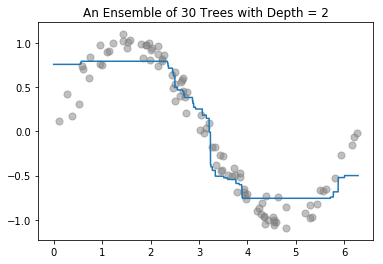

In [14]:
# Part 1: let number of decision trees increase dramatically, but keep max_depth fixed and small
# TODO clean up this code
many_tree_ensemble = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=5*num_trees,  # 5x previous tree count 
    max_depth=max_depth,    # leave max_depth as before
    bootstrap=True
)

plt.title(f'An Ensemble of {5*num_trees} Trees with Depth = {max_depth}')
plt.scatter(X, y, alpha=.5, c='gray', s=50)
y_model_plot = ensemble_predict(X_model_plot, many_tree_ensemble)
plt.plot(X_model_plot, y_model_plot)

plt.show()

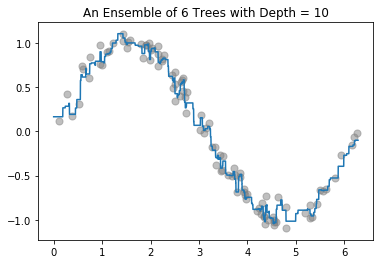

In [15]:
# Part 2: keep number of decision trees fixed, but let max_depth get big
deep_tree_ensemble = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=num_trees,    # leave tree count as before
    max_depth=5*max_depth,  # 5x previous max_depth
    bootstrap=True
)

plt.title(f'An Ensemble of {num_trees} Trees with Depth = {5*max_depth}')
plt.scatter(X, y, alpha=.5, c='gray', s=50)
y_model_plot = ensemble_predict(X_model_plot, deep_tree_ensemble)
plt.plot(X_model_plot, y_model_plot)

plt.show()

In [ ]:
# TODO plot the "previous" ensemble and these two new versions all in a row